PROJECT 3


In [88]:
import numpy as np
from numpy.linalg import inv
import numpy.random as rn
import matplotlib.pyplot as plt
import pickle
import cvxpy as cp
from tqdm import tqdm
%matplotlib inline



Question (1)

In [149]:
## Define the gridworld MDP class
class Gridworld(object):
    """
    Gridworld MDP.
    """
    f1 = np.array([
            [0,0,0,0,0,0,0,0,0,0], 
            [0,0,0,0,0,0,0,0,0,0], 
            [0,0,0,0,0,-10,-10,0,0,0], 
            [0,0,0,0,0,-10,-10,0,0,0],
            [0,-10,-10,0,0,0,0,0,0,0],
            [0,-10,-10,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,0],
            [0,0,-10,-10,0,0,0,0,0,0],
            [0,0,-10,-10,0,0,0,0,0,1]
        ])

    f2 = np.array([
        [0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,-100,-100,-100,0,0,0],
        [0,0,0,0,-100,0,-100,0,0,0],
        [0,0,0,0,-100,0,-100,-100,-100,0],
        [0,0,0,0,-100,0,0,0,-100,0],
        [0,0,0,0,-100,0,0,0,-100,0],
        [0,0,0,0,-100,0,0,0,-100,0],
        [0,0,0,0,0,0,-100,-100,-100,0],
        [0,0,0,0,0,0,-100,0,0,0],
        [0,0,0,0,0,0,0,0,0,10]
    ])
    
    def __init__(self, grid_size, wind, discount, reward_function):
        """
        grid_size: Grid size. int.
        wind: Chance of moving randomly. float.
        discount: MDP discount. float.
        -> Gridworld
        """

        self.actions = ((1, 0), (0, 1), (-1, 0), (0, -1))
        self.n_actions = len(self.actions)
        self.n_states = grid_size**2
        self.grid_size = grid_size
        self.wind = wind
        self.discount = discount
        self.reward_function = reward_function

        # Preconstruct the transition probability array.
        self.transition_probability = np.array(
            [[[self._transition_probability(i, j, k)
               for k in range(self.n_states)]
              for j in range(self.n_actions)]
             for i in range(self.n_states)])

    def __str__(self):
        return "Gridworld({}, {}, {})".format(self.grid_size, self.wind,
                                              self.discount)
    
    def int_to_point(self, i):
        """
        Convert a state int into the corresponding coordinate.

        i: State int.
        -> (x, y) int tuple.
        """

        return (i % self.grid_size, i // self.grid_size)

    def point_to_int(self, p):
        """
        Convert a coordinate into the corresponding state int.

        p: (x, y) tuple.
        -> State int.
        """

        return int(p[0] + p[1]*self.grid_size)

    def neighbouring(self, i, k):
        """
        Get whether two points neighbour each other. Also returns true if they
        are the same point.

        i: (x, y) int tuple.
        k: (x, y) int tuple.
        -> bool.
        """

        return abs(i[0] - k[0]) + abs(i[1] - k[1]) <= 1

    def on_corner(self,i):
        corner_points = [0,9,90,99]
        return i in corner_points

    def on_edge(self,i):
        edge_points = [1,2,3,4,5,6,7,8,
                       10,19,20,29,30,39,40,49,50,59,60,69,70,79,80,89,
                       91,92,93,94,95,96,97,98]
        return i in edge_points

    def moving_off_grid(self,xi,xj,yi,yj,k):
        if k < 0 or k > 99 or \
            (xi + xj < 0 or xi + xj > 9) or \
            (yi + yj < 0 or yi + yj > 9):
          return True
        
        return False

    def _transition_probability(self, i, j, k):
        """
        Get the probability of transitioning from state i to state k given
        action j.

        i: State int.
        j: Action int.
        k: State int.
        -> p(s_k | s_i, a_j)
        """

        xi, yi = self.int_to_point(i)
        xj, yj = self.actions[j]
        xk, yk = self.int_to_point(k)
        
        if not self.neighbouring((xi, yi), (xk, yk)):
            return 0

        # Is k the intended state to move to?
        if (xi + xj, yi + yj) == (xk, yk):
            return 1 - self.wind*(3/4)

        # If these are not the same point, then we can move there by wind.
        if (xi, yi) != (xk, yk):
            return self.wind / 4
        
        # Same point, corner?
        if self.on_corner(i):
            # intend to move off grid?
            if self.moving_off_grid(xi,xj,yi,yj,k):
                return 1 - self.wind * 1/2
            else:
                # blow off the grid by wind.
                return self.wind * 1/2
        else:
            # Not a corner. Is it an edge?
            if not self.on_edge(i):
                return 0
            else:#it is an edge
                # intend to move off grid?
                if self.moving_off_grid(xi,xj,yi,yj,k):
                    return 1 - self.wind*(3/4)
                else:
                    # blow off the grid by wind.
                    return self.wind / 4

    def reward(self, state_int):
        """
        Reward for being in state state_int.

        state_int: State integer. int.
        -> Reward.
        """
        #look at figure 6,7 to return a reward at the given state. 
        xi, yi = self.int_to_point(state_int)
        if self.reward_function == 1:
            reward_val = self.f1[xi,yi]
        else:
            reward_val = self.f2[xi,yi]
        
        return reward_val

    @property
    def reward_array(self):
        if self.reward_function == 1:
            return self.f1
        else:
            return self.f2

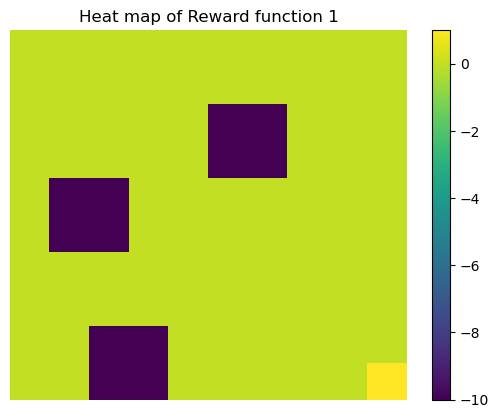

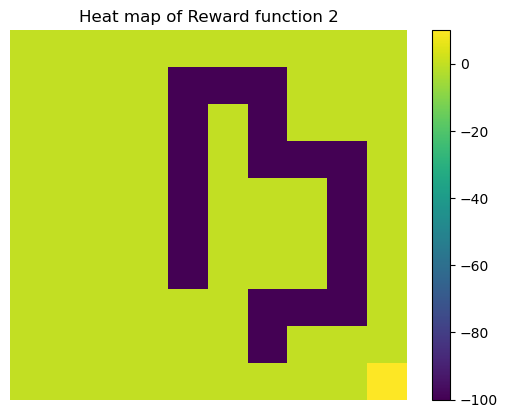

In [194]:
## For visualization generating the heat map of the ground truth reward
plt.pcolor(np.flipud(Gridworld.f1))
plt.colorbar()
plt.axis('off')
plt.title('Heat map of Reward function 1')
plt.show()

plt.pcolor(np.flipud(Gridworld.f2))
plt.colorbar()
plt.axis('off')
plt.title('Heat map of Reward function 2')
plt.show()

Question (2)

In [240]:
class Agent:
    '''
    Agent class for the gridworld MDP.

    The agent is initialized with a gridworld MDP and an initial policy.
    The agent can then update its policy using value iteration.

    The agent can:
    - generate trajectories from its policy
    - evaluate the performance of its policy
    - generate a heat map of the value function
    - generate a heat map of the policy
    - generate a heat map of the ground truth reward
    - generate a heat map of the reward function

    Variables
    ---------
    gw: Gridworld
        The gridworld MDP.
    value_matrix: np.ndarray
        The value function for the agent's policy.
    optimal_policy: np.ndarray
        The optimal policy for the agent's MDP.
    action_matrix: np.ndarray
        The optimal policy for the agent's MDP in matrix form.

    Methods
    -------
    optimal_value
        Compute the optimal value function for the agent's MDP.
    find_policy
        Compute the optimal policy for the agent's MDP.
    '''

    def __init__(self, gw: Gridworld):
        self.gw = gw
        v, _ = self.optimal_value(gw.n_states, gw.n_actions, gw.transition_probability, gw.reward_array.T.flatten(), gw.discount)
        self.value_matrix = np.zeros((grid_size, grid_size))
        for i in range(gw.n_states):
            self.value_matrix[int(i%grid_size)][int(i/grid_size)] = round(v[i], 1)

        self.optimal_policy = find_policy(gw.n_states, gw.n_actions, gw.transition_probability, gw.reward_array.T.flatten(), gw.discount, stochastic=False)
        self.action_matrix = self.optimal_policy.reshape((grid_size, grid_size)).T.astype(int)

    ## Implementing the algorithm for computing the optimal value function for each state
    ## The algorithm takes as input the MDP and returns an array of optimal values,
    ## where i^th value in the array corresponds to the optimal value of the i^th state.
    @staticmethod
    def optimal_value(n_states, n_actions, transition_probabilities, reward,
                    discount, threshold=1e-2):
        """Find the optimal value function.

        Lines 6-13 of the value iteration algorithm.

        n_states: Number of states. int.
        n_actions: Number of actions. int.
        transition_probabilities: Function taking (state, action, state) to
            transition probabilities.
        reward: Vector of rewards for each state.
        discount: MDP discount factor. float.
        threshold: Convergence threshold, default 1e-2. float.
        -> Array of values for each state
        """
        # Intialization
        v = np.zeros(n_states)

        # Estimation
        delta = 1 + threshold
        count = 0
        steps = np.linspace(1, 21, 5)
        v_steps = []
        
        while delta > threshold:
            delta = 0
            count += 1
            
            for state in range(n_states):
                v_old = v[state]
                trans_prob_tmp = np.zeros(n_actions)
                
                for action in range(n_actions):
                    for next_state in range(n_states):
                        trans_prob_tmp[action] += transition_probabilities[state, action, next_state] * \
                            (reward[next_state] + discount * v[next_state])
                v[state] = np.max(trans_prob_tmp)
                delta = max(delta, abs(v_old - v[state]))
            
            if count in steps:
                v_steps.append(v.copy())

        return v, v_steps

    ## Implementing the function for computing the optimal policy.
    ## The function takes as input the MDP and outputs a
    ## deterministic policy, which is an array of actions.
    ## The i^th entry in the array corresponds to the
    ## optimal action to take at the i^th state.
    @staticmethod
    def find_policy(n_states, n_actions, transition_probabilities, reward, discount,
                    threshold=1e-2, v=None, stochastic=False):
        """
        Find the optimal value function.

        n_states: Number of states. int.
        n_actions: Number of actions. int.
        transition_probabilities: Function taking (state, action, state) to
            transition probabilities.
        reward: Vector of rewards for each state.
        discount: MDP discount factor. float.
        threshold: Convergence threshold, default 1e-2. float.
        -> Array of values for each state
        """
        if v is None:
            v, _ = Agent.optimal_value(n_states, n_actions, transition_probabilities, reward, discount)

        # Computation:
        policy = np.zeros(n_states)
        for state in range(n_states):
            trans_prob_tmp = np.zeros(n_actions)
            for action in range(n_actions):
                for next_state in range(n_states):
                    trans_prob_tmp[action] += transition_probabilities[state, action, next_state] * \
                        (reward[next_state] + discount * v[next_state])
            
            policy[state] = np.argmax(trans_prob_tmp)
        
        return policy

    ## Function for plotting the matrix values
    def plot_value_matrix(self):
        matrix = self.value_matrix
        fig, ax = plt.subplots()
        num_rows = len(matrix)
        min_val, max_val = 0, num_rows

        for i in range(num_rows):
            for j in range(num_rows):
                c = matrix[i][j]
                ax.text(j + 0.5, i + 0.5, '{:.1f}'.format(c), va='center', ha='center')

        ax.set_xlim(min_val, max_val)
        ax.set_ylim(max_val, min_val)
        ax.set_xticks(np.arange(max_val))
        ax.set_yticks(np.arange(max_val))
        ax.xaxis.tick_top()
        ax.grid()
        plt.show()
        plt.close()

    def plot_reward_heatmap(self):  
        ## For visualization generating the heat map of the optimal state values
        plt.pcolor(np.flipud(self.value_matrix))
        plt.colorbar()
        plt.axis('off')
        plt.title(f'Heat map of optimal state values for Reward function {self.gw.reward_function}')
        plt.show()

    def plot_arrow(self):
        """Function for plotting the optimal actions at each state in the grid
        The function takes as input the matrix containing optimal actions
        and plots the actions for each state on the grid
        """
        _, ax = plt.subplots()
        num_rows = len(self.action_matrix)
        min_val, max_val = 0, num_rows
        arrow_dict = {0:u'↓', 1:u'→', 2:u'↑', 3:u'←'}

        for i in range(num_rows):
            for j in range(num_rows):
                ax.text(j + 0.5, i + 0.5, arrow_dict[self.action_matrix[i][j]], va='center', ha='center')

        ax.set_xlim(min_val, max_val)
        ax.set_ylim(max_val, min_val)
        ax.set_xticks(np.arange(max_val))
        ax.set_yticks(np.arange(max_val))
        ax.xaxis.tick_top()
        ax.grid()

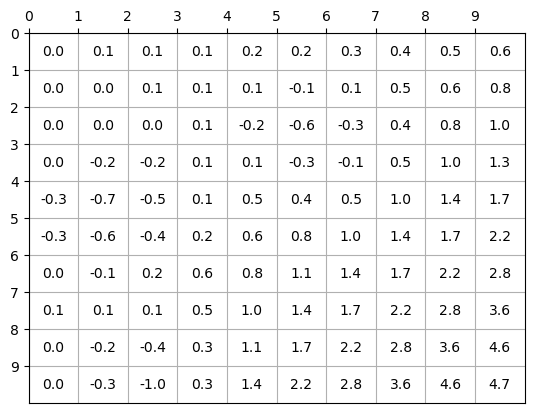

In [241]:
gw = Gridworld(grid_size=10, wind=0.1, discount=0.8, reward_function=1)
agent = Agent(gw)
agent.plot_value_matrix()

Question (3)

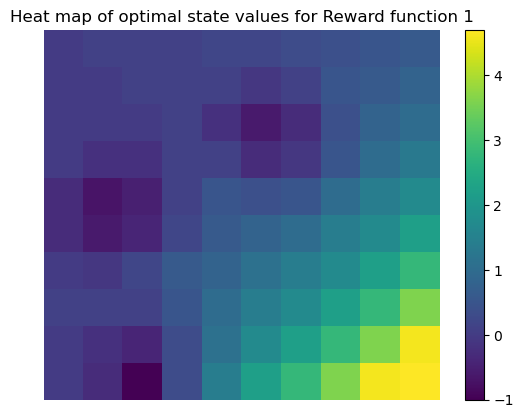

In [226]:
agent.plot_reward_heatmap()

Question (4):

The values are higher for areas that are far from the penalties

Question (5):

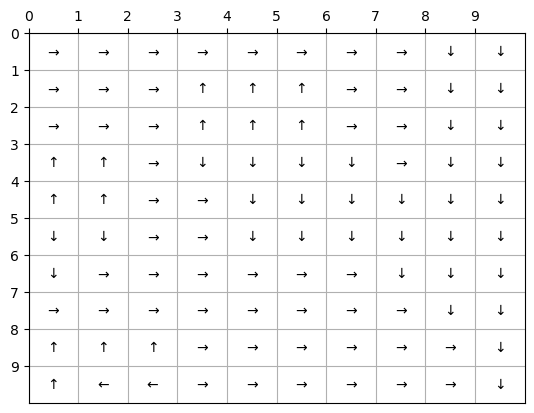

In [227]:
agent.plot_arrow()

Question(6)

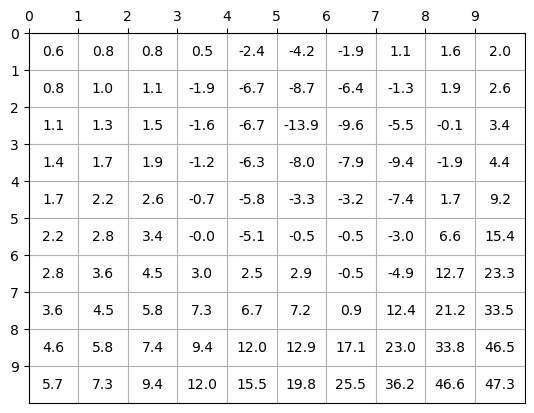

In [228]:
gw = Gridworld(grid_size=10, wind=0.1, discount=0.8, reward_function=2)
agent = Agent(gw)
agent.plot_value_matrix()

Question(7)

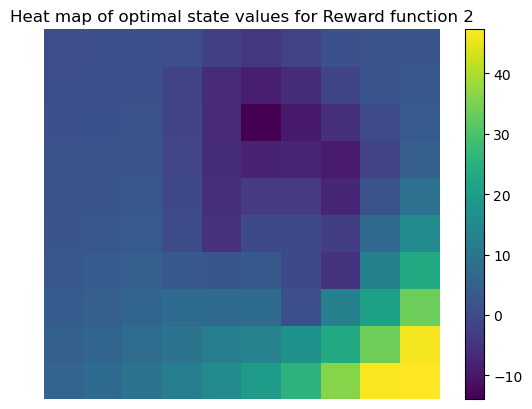

In [229]:
agent.plot_reward_heatmap()

Question(8)

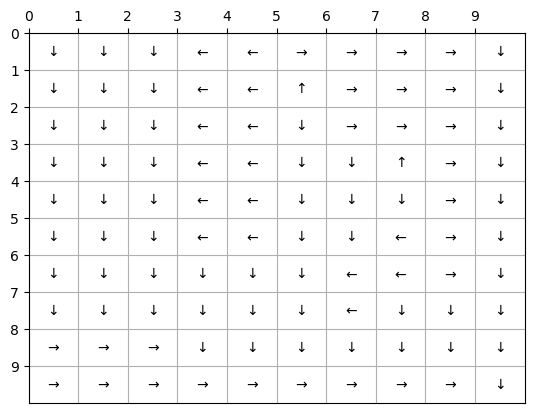

In [230]:
agent.plot_arrow()

Question(9)

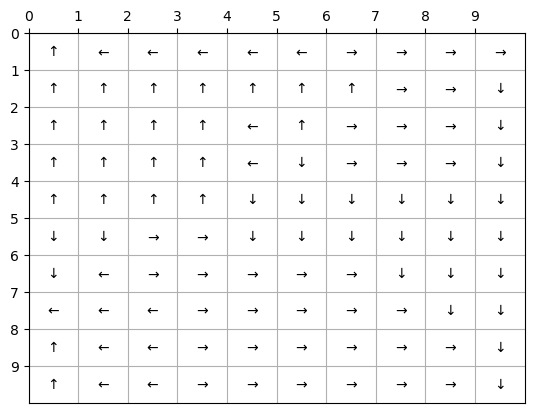

In [231]:
gw = Gridworld(grid_size=10, wind=0.6, discount=0.8, reward_function=1)
agent = Agent(gw)
agent.plot_arrow()

Question(11)

In [128]:
def accuracy(expected_policy, test_policy):
    return np.sum(expected_policy == test_policy) / len(expected_policy)

In [242]:
gw = Gridworld(grid_size=10, wind=0.1, discount=0.8, reward_function=1)
agent = Agent(gw)
optimal_policy = agent.optimal_policy

In [251]:
n_lambdas = 10
lambdas = np.linspace(0, 5, n_lambdas)
accuracies = np.empty(n_lambdas)

R_max = max(f1.max(), f2.max())
a1 = int(optimal_policy[0])
R = cp.Variable((gw.n_states, 1))
t = cp.Variable((gw.n_states, 1))
u = cp.Variable((gw.n_states, 1))
constraints = [
    R <= R_max,
    R >= -R_max,
    # t >= 0,
    u >= 0,
    R <= u,
    R >= -u
]
for a in range(gw.n_actions):
    if a != a1:
        P_a = gw.transition_probability[:,a]
        P_a1 = gw.transition_probability[:,a1]
        constraints.append((P_a1 - P_a) @ inv(np.eye(gw.n_states) - gw.discount * P_a1) @ R >= 0)
        # constraints.append((P_a1 - P_a) @ inv(np.eye(gw.n_states) - l * P_a1) @ R >= t)

        for j in range(gw.n_states):
            P_ai = P_a[j] # P_a[:,i]
            P_a1i = P_a1[j] # P_a1[:,i]
            # P_ai = P_a[:,j]
            # P_a1i = P_a1[:,j]
            constraints.append((P_a1i - P_ai) @ inv(np.eye(gw.n_states) - gw.discount * P_a1) @ R >= t[j])

for i, l in enumerate(tqdm(lambdas)):
    cp.Problem(cp.Maximize(cp.sum(t) - l * cp.sum(u)), constraints).solve()
    irl_policy = Agent.find_policy(gw.n_states, gw.n_actions, gw.transition_probability, R.value, gw.discount, stochastic=False)
    accuracies[i] = accuracy(optimal_policy, irl_policy)

plt.plot(lambdas, accuracies)
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Lambda (Reward function 2)')
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]